In [4]:
!git clone https://github.com/Oliverluyu/brain_tumor_img_segmentation.git
%cd brain_tumor_img_segmentation
!git checkout experiment2


Cloning into 'brain_tumor_img_segmentation'...
remote: Enumerating objects: 13181, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 13181 (delta 10), reused 22 (delta 6), pack-reused 13149
Receiving objects: 100% (13181/13181), 526.88 MiB | 38.28 MiB/s, done.
Resolving deltas: 100% (564/564), done.
Updating files: 100% (15653/15653), done.
/content/brain_tumor_img_segmentation
Branch 'experiment2' set up to track remote branch 'experiment2' from 'origin'.
Switched to a new branch 'experiment2'


# Transfer learning from about classifaction model

ongoing: need to add accuracy, add Segmentation Metrics
https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch/blob/master/readme.md


In [2]:
# import os
# from PIL import Image
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# import torch.nn.functional as F
# from models.network_helper import init_weights
# import torchvision.transforms as transforms
# import torch.optim as optim
# from models.VanillaUnet import unet_2D
# import matplotlib.pyplot as plt


# class BrainTumorDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_dir = os.path.join(root_dir, 'images')
#         self.mask_dir = os.path.join(root_dir, 'masks')
#         self.image_paths = self._get_paths(self.image_dir)
#         self.mask_paths = self._get_paths(self.mask_dir)

#     def _get_paths(self, directory):
#         paths = []
#         for subdir in os.listdir(directory):
#             subdir_path = os.path.join(directory, subdir)
#             if os.path.isdir(subdir_path):
#                 for filename in os.listdir(subdir_path):
#                     paths.append(os.path.join(subdir_path, filename))
#         return paths

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         mask_path = self.mask_paths[idx]
#         image = Image.open(img_path)
#         mask = Image.open(mask_path)
#         # image = Image.open(img_path).convert('L')  # Keep as grayscale
#         # mask = Image.open(mask_path).convert('L')  # Keep as grayscale
#         if self.transform:
#             image = self.transform(image)
#             mask = self.transform(mask)
#         return image, mask


# # Define transforms
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
#     transforms.Resize((256, 256)),
#     transforms.ToTensor()
# ])

# # Initialize dataset and dataloaders
# train_dataset = BrainTumorDataset(root_dir='datasets/segmentation/train',
#                                   transform=transform)
# test_dataset = BrainTumorDataset(root_dir='datasets/segmentation/test',
#                                  transform=transform)
# val_dataset = BrainTumorDataset(root_dir='datasets/segmentation/validation',
#                                 transform=transform)

# # Define dataloaders
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# # Define VanillaUnet model for segmentation
# model = unet_2D(in_channels=1, mode='segmentation')  # Assuming segmentation task setup

# # Load the pretrained classification model
# classification_model_path = 'saved_models/classification_model_20epochs.pth'
# model.load_state_dict(torch.load(classification_model_path))

# # Adjust the model for segmentation if necessary
# # This step might be redundant if the model is already initialized for segmentation
# model.mode = 'segmentation'

# # Freeze the encoder weights
# model.freeze_encoder()

# # Proceed with the setup for training, such as defining loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# training_losses = []
# validation_losses = []

# # Training loop
# num_epochs = 1
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for batch in train_loader:
#         images, masks = batch
#         images, masks = images.to(device), masks.to(device)

#         optimizer.zero_grad()

#         outputs = model(images)

#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         # print(loss.item() ,running_loss)

#     epoch_loss = running_loss / len(train_dataset)

#     # Validation
#     model.eval()
#     val_running_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             images, masks = batch
#             images, masks = images.to(device), masks.to(device)
#             outputs = model(images)
#             val_loss = criterion(outputs, masks)
#             val_running_loss += val_loss.item() * images.size(0)

#             image_plot1 = masks[0,0].cpu().numpy()   # Assuming images are grayscale
#             image_plot2 = outputs[0,0].detach().cpu().numpy() # Assuming images are grayscale
#         plt.subplot(1, 2, 1)  # Adjust subplot layout for multiple images
#         plt.imshow(image_plot1, cmap='gray')
#         plt.subplot(1, 2, 2)  # Adjust subplot layout for multiple images
#         plt.imshow(image_plot2, cmap='gray')
#         plt.axis('off')
#         plt.show()
#     val_epoch_loss = val_running_loss / len(val_dataset)

#     training_losses.append(epoch_loss)
#     validation_losses.append(val_epoch_loss)
#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

# # After the training loop, plot the training and validation loss
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# def calculate_pixel_accuracy(predicted, true):
#     """Calculate pixel-wise accuracy."""
#     correct = torch.eq(predicted, true).sum().item()  # Count correct pixels
#     total = torch.numel(predicted)  # Total number of pixels
#     return correct / total

# # Switch model to evaluation mode
# model.eval()

# # Track accuracy
# accuracies = []

# with torch.no_grad():
#     for images, masks in train_loader:  # Use your training DataLoader
#         images, masks = images.to(device), masks.to(device)

#         # Predict segmentation masks
#         outputs = model(images)

#         # Assuming your model outputs raw logits, you'd typically apply a threshold or argmax
#         # For simplicity, let's say your model's output is already binary or categorical
#         predicted_masks = torch.argmax(outputs, dim=1)  # Use argmax for categorical masks

#         # Calculate accuracy for the current batch and store
#         acc = calculate_pixel_accuracy(predicted_masks, masks)
#         accuracies.append(acc)

# # Calculate mean accuracy across all batches
# mean_accuracy = sum(accuracies) / len(accuracies)
# print(f"Mean accuracy on training data: {mean_accuracy * 100:.2f}%")


# def calculate_metrics(pred, target, num_classes=2, ignore_background=True):
#     """
#     Calculate segmentation metrics.
#     Args:
#     - pred (torch.Tensor): Predicted segmentation map, shape (N, H, W)
#     - target (torch.Tensor): Ground truth segmentation map, shape (N, H, W)
#     - num_classes (int): Number of classes in the segmentation task
#     - ignore_background (bool): If True, ignore metrics for the background class (assumed to be 0)
#     Returns:
#     - metrics (dict): Dictionary containing pixel accuracy, Dice, precision, recall, and specificity
#     """
#     # Initialize confusion matrix
#     conf_matrix = torch.zeros(num_classes, num_classes)
#     for t, p in zip(target.view(-1), pred.view(-1)):
#         conf_matrix[t.long(), p.long()] += 1

#     # Ignore background class if needed
#     start_index = 1 if ignore_background else 0

#     # Initialize metrics
#     metrics = {
#         'pixel_accuracy': 0,
#         'dice': [],
#         'precision': [],
#         'recall': [],
#         'specificity': []
#     }

#     # Calculate metrics per class
#     for i in range(start_index, num_classes):
#         TP = conf_matrix[i, i]
#         FP = conf_matrix[:, i].sum() - TP
#         FN = conf_matrix[i, :].sum() - TP
#         TN = conf_matrix.sum() - (TP + FP + FN)

#         pixel_accuracy = (TP + TN) / conf_matrix.sum()
#         dice = (2 * TP) / (2 * TP + FP + FN)
#         precision = TP / (TP + FP)
#         recall = TP / (TP + FN)
#         specificity = TN / (TN + FP)

#         metrics['dice'].append(dice.item())
#         metrics['precision'].append(precision.item())
#         metrics['recall'].append(recall.item())
#         metrics['specificity'].append(specificity.item())

#     metrics['pixel_accuracy'] = pixel_accuracy.item()
#     metrics['dice'] = sum(metrics['dice']) / len(metrics['dice'])
#     metrics['precision'] = sum(metrics['precision']) / len(metrics['precision'])
#     metrics['recall'] = sum(metrics['recall']) / len(metrics['recall'])
#     metrics['specificity'] = sum(metrics['specificity']) / len(metrics['specificity'])

#     return metrics

# # Example usage
# with torch.no_grad():
#     for images, masks in test_loader:  # Assuming test_loader is your DataLoader
#         images, masks = images.to(device), masks.to(device)
#         outputs = model(images)
#         preds = torch.argmax(outputs, dim=1)
#         metrics = calculate_metrics(preds, masks, num_classes=2)  # Adjust num_classes accordingly

#         print(metrics)




trying IoU and Dice coefficient

Epoch 1/10, Training Loss: 0.0135, Validation Loss: 0.0336, Avg Dice Score: 0.4375, Avg IoU: 0.3548, Avg F1 Score: 0.2515, Avg Pixel Accuracy: 0.9885
Epoch 2/10, Training Loss: 0.0085, Validation Loss: 0.0382, Avg Dice Score: 0.4670, Avg IoU: 0.3663, Avg F1 Score: 0.3275, Avg Pixel Accuracy: 0.9878
Epoch 3/10, Training Loss: 0.0077, Validation Loss: 0.0279, Avg Dice Score: 0.5416, Avg IoU: 0.4444, Avg F1 Score: 0.3498, Avg Pixel Accuracy: 0.9898
Epoch 4/10, Training Loss: 0.0071, Validation Loss: 0.0296, Avg Dice Score: 0.5545, Avg IoU: 0.4452, Avg F1 Score: 0.3917, Avg Pixel Accuracy: 0.9897
Epoch 5/10, Training Loss: 0.0066, Validation Loss: 0.0313, Avg Dice Score: 0.5412, Avg IoU: 0.4340, Avg F1 Score: 0.4133, Avg Pixel Accuracy: 0.9884
Epoch 6/10, Training Loss: 0.0063, Validation Loss: 0.0241, Avg Dice Score: 0.6263, Avg IoU: 0.5250, Avg F1 Score: 0.3938, Avg Pixel Accuracy: 0.9906
Epoch 7/10, Training Loss: 0.0060, Validation Loss: 0.0247, Avg Dice Score: 0.5324, Avg IoU: 0.4302,

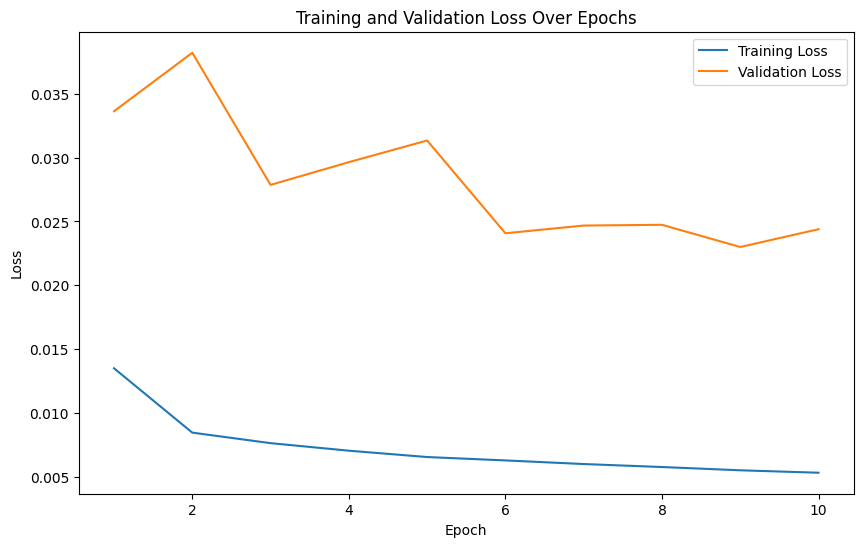

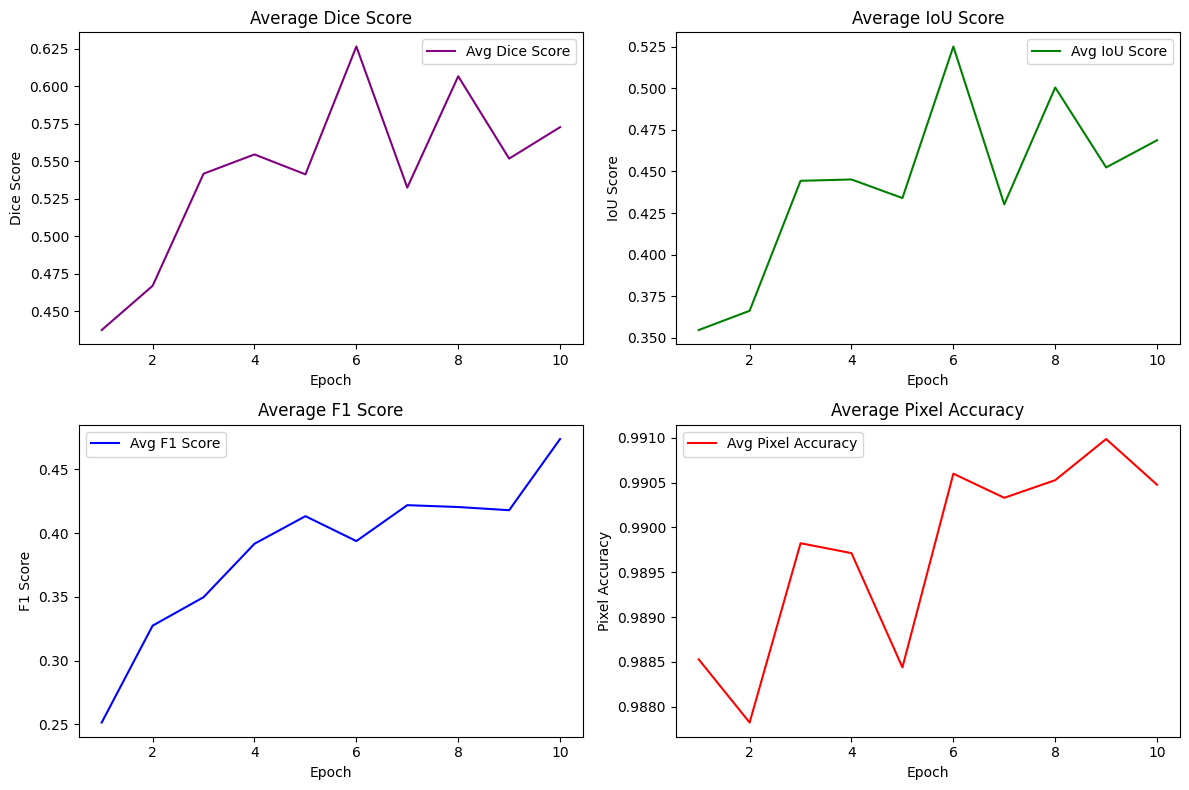

Test Loss: 0.0211, Avg Dice Score: 0.6316, Avg IoU: 0.5285, Avg F1 Score: 0.5101, Avg Pixel Accuracy: 0.9916


In [5]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt


def dice_coefficient(pred, target):
    smooth = 1e-5
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def iou_score(pred, target):
    smooth = 1e-5
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def f1_score(pred, target):
    # Calculate F1 score
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    precision = (pred_flat * target_flat).sum() / (pred_flat.sum() + 1e-5)
    recall = (pred_flat * target_flat).sum() / (target_flat.sum() + 1e-5)
    f1 = 2 * precision * recall / (precision + recall + 1e-5)

    return f1

def pixel_accuracy(pred, target):
    # Calculate pixel-wise accuracy
    correct = (pred == target).sum()
    total = target.numel()
    return correct.float() / total


class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.image_paths = self._get_paths(self.image_dir)
        self.mask_paths = self._get_paths(self.mask_dir)

    def _get_paths(self, directory):
        paths = []
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                for filename in os.listdir(subdir_path):
                    paths.append(os.path.join(subdir_path, filename))
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # image = Image.open(img_path).convert('L')  # Keep as grayscale
        # mask = Image.open(mask_path).convert('L')  # Keep as grayscale
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Initialize dataset and dataloaders
train_dataset = BrainTumorDataset(root_dir='datasets/segmentation/train',
                                  transform=transform)
test_dataset = BrainTumorDataset(root_dir='datasets/segmentation/test',
                                 transform=transform)
val_dataset = BrainTumorDataset(root_dir='datasets/segmentation/validation',
                                transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define VanillaUnet model for segmentation
model = unet_2D(in_channels=1, mode='segmentation')  # Assuming segmentation task setup

# Load the pretrained classification model
classification_model_path = 'saved_models/classification_model_20epochs.pth'
model.load_state_dict(torch.load(classification_model_path))

# Adjust the model for segmentation if necessary
# This step might be redundant if the model is already initialized for segmentation
model.mode = 'segmentation'

# Freeze the encoder weights
model.freeze_encoder()

# Proceed with the setup for training, such as defining loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_losses = []
validation_losses = []
avg_dice_scores = []
avg_iou_scores = []
avg_f1_scores = []
avg_pixel_accuracies = []

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)


    # Validation loop
    model.eval()
    val_running_loss = 0.0
    dice_scores = []
    iou_scores = []
    f1_scores = []
    pixel_accuracies = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            val_running_loss += val_loss.item() * images.size(0)

            preds = outputs > 0.5
            dice_scores.append(dice_coefficient(preds.float(), masks).item())
            iou_scores.append(iou_score(preds.float(), masks).item())
            f1_scores.append(f1_score(preds.float(), masks).item())
            pixel_accuracies.append(pixel_accuracy(preds, masks).item())

    # Calculate and store average metrics for the epoch
    val_epoch_loss = val_running_loss / len(val_loader)
    validation_losses.append(val_epoch_loss)
    avg_dice_scores.append(sum(dice_scores) / len(dice_scores))
    avg_iou_scores.append(sum(iou_scores) / len(iou_scores))
    avg_f1_scores.append(sum(f1_scores) / len(f1_scores))
    avg_pixel_accuracies.append(sum(pixel_accuracies) / len(pixel_accuracies))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Avg Dice Score: {avg_dice_scores[-1]:.4f}, Avg IoU: {avg_iou_scores[-1]:.4f}, Avg F1 Score: {avg_f1_scores[-1]:.4f}, Avg Pixel Accuracy: {avg_pixel_accuracies[-1]:.4f}")

# After the training loop, plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ensure you have these lists ready with values from each epoch
# avg_dice_scores = [...]
# avg_iou_scores = [...]

# Plotting training and validation loss
plt.figure(figsize=(12, 8))


# Plotting Dice scores
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), avg_dice_scores, label='Avg Dice Score', color='purple')
plt.title('Average Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

# Plotting IoU scores
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), avg_iou_scores, label='Avg IoU Score', color='green')
plt.title('Average IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

# Plotting F1 scores
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), avg_f1_scores, label='Avg F1 Score', color='blue')
plt.title('Average F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plotting Pixel-wise Accuracies
plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), avg_pixel_accuracies, label='Avg Pixel Accuracy', color='red')
plt.title('Average Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming model, criterion, and test_loader are already defined and the model is trained
test_running_loss = 0.0
dice_scores = []
iou_scores = []
f1_scores = []
pixel_accuracies = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_loss = criterion(outputs, masks)
        test_running_loss += test_loss.item() * images.size(0)

        preds = outputs > 0.5  # Threshold predictions
        dice_scores.append(dice_coefficient(preds.float(), masks).item())
        iou_scores.append(iou_score(preds.float(), masks).item())
        f1_scores.append(f1_score(preds.float(), masks).item())
        pixel_accuracies.append(pixel_accuracy(preds, masks).item())

# Calculate average metrics across all test data
avg_dice_score = sum(dice_scores) / len(dice_scores)
avg_iou_score = sum(iou_scores) / len(iou_scores)
avg_f1_score = sum(f1_scores) / len(f1_scores)
avg_pixel_accuracy = sum(pixel_accuracies) / len(pixel_accuracies)
test_loss = test_running_loss / len(test_loader)

# Print the test metrics
print(f"Test Loss: {test_loss:.4f}, Avg Dice Score: {avg_dice_score:.4f}, Avg IoU: {avg_iou_score:.4f}, Avg F1 Score: {avg_f1_score:.4f}, Avg Pixel Accuracy: {avg_pixel_accuracy:.4f}")

model_save_path = 'saved_models/trained_model_tf_1.pth'
os.makedirs('saved_models', exist_ok=True)
torch.save(model.state_dict(), model_save_path)

Epoch 1/10, Training Loss: 0.0140, Validation Loss: 0.0373, Avg Dice Score: 0.3915, Avg IoU: 0.3201, Avg F1 Score: 0.1997, Avg Pixel Accuracy: 0.9882
Epoch 2/10, Training Loss: 0.0085, Validation Loss: 0.0400, Avg Dice Score: 0.4542, Avg IoU: 0.3516, Avg F1 Score: 0.3495, Avg Pixel Accuracy: 0.9855
Epoch 3/10, Training Loss: 0.0077, Validation Loss: 0.0278, Avg Dice Score: 0.5236, Avg IoU: 0.4273, Avg F1 Score: 0.3550, Avg Pixel Accuracy: 0.9898
Epoch 4/10, Training Loss: 0.0072, Validation Loss: 0.0300, Avg Dice Score: 0.5353, Avg IoU: 0.4397, Avg F1 Score: 0.3377, Avg Pixel Accuracy: 0.9895
Epoch 5/10, Training Loss: 0.0069, Validation Loss: 0.0279, Avg Dice Score: 0.5998, Avg IoU: 0.4981, Avg F1 Score: 0.3963, Avg Pixel Accuracy: 0.9901
Epoch 6/10, Training Loss: 0.0066, Validation Loss: 0.0282, Avg Dice Score: 0.5162, Avg IoU: 0.4216, Avg F1 Score: 0.3592, Avg Pixel Accuracy: 0.9899
Epoch 7/10, Training Loss: 0.0063, Validation Loss: 0.0269, Avg Dice Score: 0.5862, Avg IoU: 0.4918,

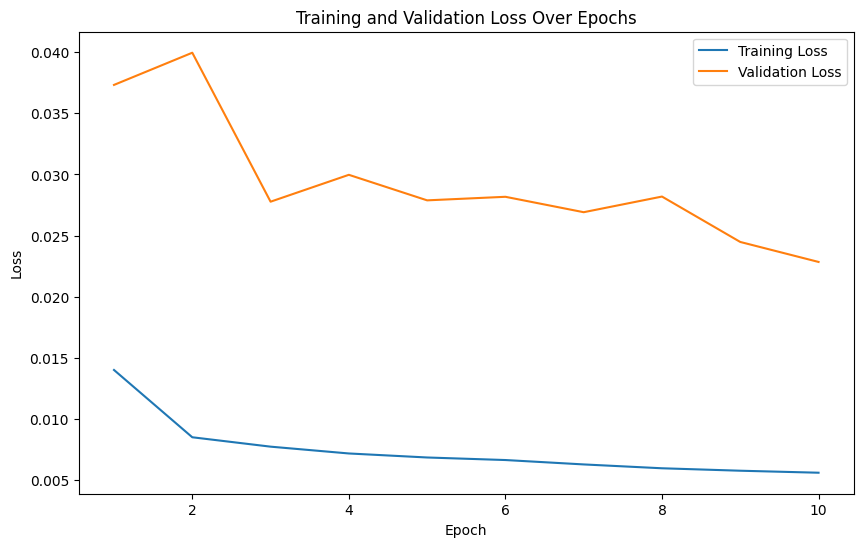

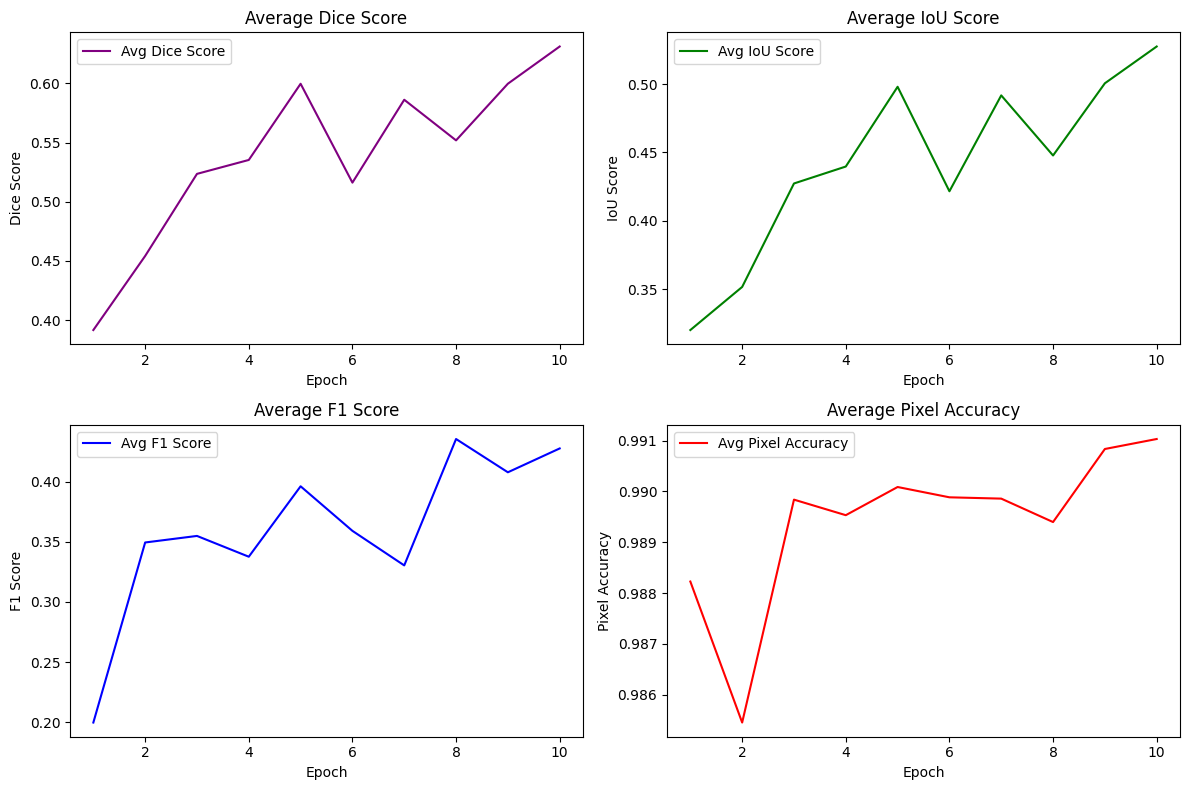

Test Loss: 0.0210, Avg Dice Score: 0.6852, Avg IoU: 0.5811, Avg F1 Score: 0.4515, Avg Pixel Accuracy: 0.9915


In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt


def dice_coefficient(pred, target):
    smooth = 1e-5
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def iou_score(pred, target):
    smooth = 1e-5
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def f1_score(pred, target):
    # Calculate F1 score
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    precision = (pred_flat * target_flat).sum() / (pred_flat.sum() + 1e-5)
    recall = (pred_flat * target_flat).sum() / (target_flat.sum() + 1e-5)
    f1 = 2 * precision * recall / (precision + recall + 1e-5)

    return f1

def pixel_accuracy(pred, target):
    # Calculate pixel-wise accuracy
    correct = (pred == target).sum()
    total = target.numel()
    return correct.float() / total


class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.image_paths = self._get_paths(self.image_dir)
        self.mask_paths = self._get_paths(self.mask_dir)

    def _get_paths(self, directory):
        paths = []
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                for filename in os.listdir(subdir_path):
                    paths.append(os.path.join(subdir_path, filename))
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # image = Image.open(img_path).convert('L')  # Keep as grayscale
        # mask = Image.open(mask_path).convert('L')  # Keep as grayscale
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Initialize dataset and dataloaders
train_dataset = BrainTumorDataset(root_dir='datasets/segmentation/train',
                                  transform=transform)
test_dataset = BrainTumorDataset(root_dir='datasets/segmentation/test',
                                 transform=transform)
val_dataset = BrainTumorDataset(root_dir='datasets/segmentation/validation',
                                transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define VanillaUnet model for segmentation
model = unet_2D(in_channels=1, mode='segmentation')  # Assuming segmentation task setup

# Load the pretrained classification model
classification_model_path = 'saved_models/classification_model_20epochs_0p1.pth'
model.load_state_dict(torch.load(classification_model_path))

# Adjust the model for segmentation if necessary
# This step might be redundant if the model is already initialized for segmentation
model.mode = 'segmentation'

# Freeze the encoder weights
model.freeze_encoder()

# Proceed with the setup for training, such as defining loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_losses = []
validation_losses = []
avg_dice_scores = []
avg_iou_scores = []
avg_f1_scores = []
avg_pixel_accuracies = []

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)


    # Validation loop
    model.eval()
    val_running_loss = 0.0
    dice_scores = []
    iou_scores = []
    f1_scores = []
    pixel_accuracies = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            val_running_loss += val_loss.item() * images.size(0)

            preds = outputs > 0.5
            dice_scores.append(dice_coefficient(preds.float(), masks).item())
            iou_scores.append(iou_score(preds.float(), masks).item())
            f1_scores.append(f1_score(preds.float(), masks).item())
            pixel_accuracies.append(pixel_accuracy(preds, masks).item())

    # Calculate and store average metrics for the epoch
    val_epoch_loss = val_running_loss / len(val_loader)
    validation_losses.append(val_epoch_loss)
    avg_dice_scores.append(sum(dice_scores) / len(dice_scores))
    avg_iou_scores.append(sum(iou_scores) / len(iou_scores))
    avg_f1_scores.append(sum(f1_scores) / len(f1_scores))
    avg_pixel_accuracies.append(sum(pixel_accuracies) / len(pixel_accuracies))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Avg Dice Score: {avg_dice_scores[-1]:.4f}, Avg IoU: {avg_iou_scores[-1]:.4f}, Avg F1 Score: {avg_f1_scores[-1]:.4f}, Avg Pixel Accuracy: {avg_pixel_accuracies[-1]:.4f}")

# After the training loop, plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ensure you have these lists ready with values from each epoch
# avg_dice_scores = [...]
# avg_iou_scores = [...]

# Plotting training and validation loss
plt.figure(figsize=(12, 8))


# Plotting Dice scores
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), avg_dice_scores, label='Avg Dice Score', color='purple')
plt.title('Average Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

# Plotting IoU scores
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), avg_iou_scores, label='Avg IoU Score', color='green')
plt.title('Average IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

# Plotting F1 scores
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), avg_f1_scores, label='Avg F1 Score', color='blue')
plt.title('Average F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plotting Pixel-wise Accuracies
plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), avg_pixel_accuracies, label='Avg Pixel Accuracy', color='red')
plt.title('Average Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming model, criterion, and test_loader are already defined and the model is trained
test_running_loss = 0.0
dice_scores = []
iou_scores = []
f1_scores = []
pixel_accuracies = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_loss = criterion(outputs, masks)
        test_running_loss += test_loss.item() * images.size(0)

        preds = outputs > 0.5  # Threshold predictions
        dice_scores.append(dice_coefficient(preds.float(), masks).item())
        iou_scores.append(iou_score(preds.float(), masks).item())
        f1_scores.append(f1_score(preds.float(), masks).item())
        pixel_accuracies.append(pixel_accuracy(preds, masks).item())

# Calculate average metrics across all test data
avg_dice_score = sum(dice_scores) / len(dice_scores)
avg_iou_score = sum(iou_scores) / len(iou_scores)
avg_f1_score = sum(f1_scores) / len(f1_scores)
avg_pixel_accuracy = sum(pixel_accuracies) / len(pixel_accuracies)
test_loss = test_running_loss / len(test_loader)

# Print the test metrics
print(f"Test Loss: {test_loss:.4f}, Avg Dice Score: {avg_dice_score:.4f}, Avg IoU: {avg_iou_score:.4f}, Avg F1 Score: {avg_f1_score:.4f}, Avg Pixel Accuracy: {avg_pixel_accuracy:.4f}")

model_save_path = 'saved_models/trained_model_tf_2.pth'
os.makedirs('saved_models', exist_ok=True)
torch.save(model.state_dict(), model_save_path)

Epoch 1/10, Training Loss: 0.0126, Validation Loss: 0.0365, Avg Dice Score: 0.4210, Avg IoU: 0.3257, Avg F1 Score: 0.3047, Avg Pixel Accuracy: 0.9877
Epoch 2/10, Training Loss: 0.0084, Validation Loss: 0.0301, Avg Dice Score: 0.4684, Avg IoU: 0.3793, Avg F1 Score: 0.2940, Avg Pixel Accuracy: 0.9892
Epoch 3/10, Training Loss: 0.0078, Validation Loss: 0.0293, Avg Dice Score: 0.4873, Avg IoU: 0.3887, Avg F1 Score: 0.3536, Avg Pixel Accuracy: 0.9897
Epoch 4/10, Training Loss: 0.0070, Validation Loss: 0.0260, Avg Dice Score: 0.5792, Avg IoU: 0.4813, Avg F1 Score: 0.3641, Avg Pixel Accuracy: 0.9902
Epoch 5/10, Training Loss: 0.0067, Validation Loss: 0.0259, Avg Dice Score: 0.5146, Avg IoU: 0.4111, Avg F1 Score: 0.4099, Avg Pixel Accuracy: 0.9903
Epoch 6/10, Training Loss: 0.0062, Validation Loss: 0.0264, Avg Dice Score: 0.5301, Avg IoU: 0.4279, Avg F1 Score: 0.3789, Avg Pixel Accuracy: 0.9900
Epoch 7/10, Training Loss: 0.0060, Validation Loss: 0.0231, Avg Dice Score: 0.5642, Avg IoU: 0.4622,

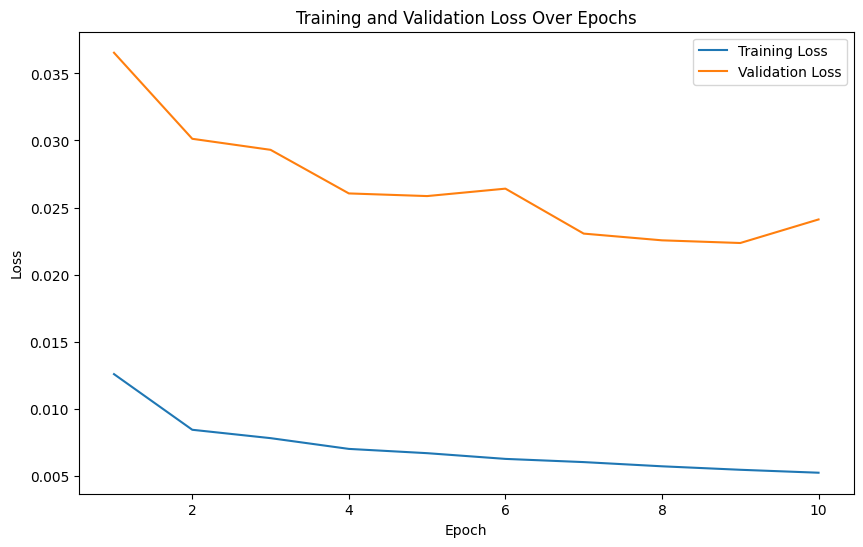

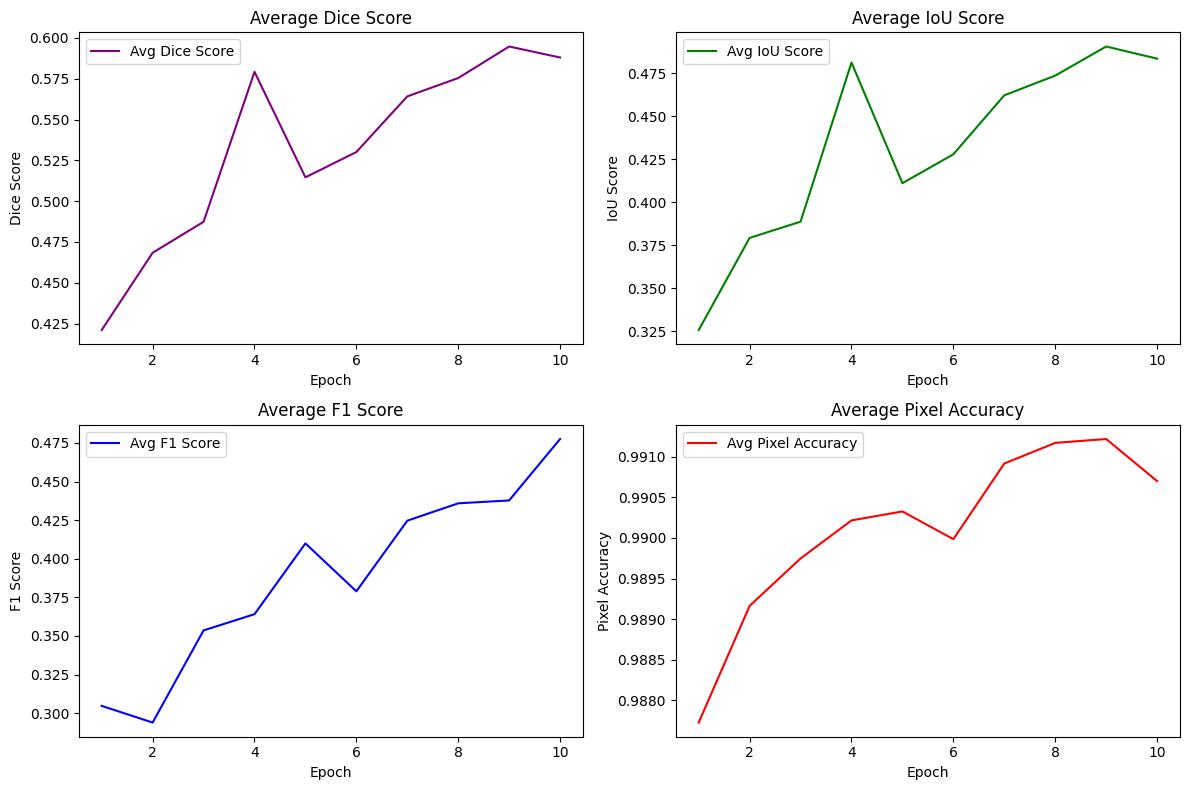

Test Loss: 0.0227, Avg Dice Score: 0.6284, Avg IoU: 0.5244, Avg F1 Score: 0.4976, Avg Pixel Accuracy: 0.9910


In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt


def dice_coefficient(pred, target):
    smooth = 1e-5
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def iou_score(pred, target):
    smooth = 1e-5
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def f1_score(pred, target):
    # Calculate F1 score
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    precision = (pred_flat * target_flat).sum() / (pred_flat.sum() + 1e-5)
    recall = (pred_flat * target_flat).sum() / (target_flat.sum() + 1e-5)
    f1 = 2 * precision * recall / (precision + recall + 1e-5)

    return f1

def pixel_accuracy(pred, target):
    # Calculate pixel-wise accuracy
    correct = (pred == target).sum()
    total = target.numel()
    return correct.float() / total


class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.image_paths = self._get_paths(self.image_dir)
        self.mask_paths = self._get_paths(self.mask_dir)

    def _get_paths(self, directory):
        paths = []
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                for filename in os.listdir(subdir_path):
                    paths.append(os.path.join(subdir_path, filename))
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # image = Image.open(img_path).convert('L')  # Keep as grayscale
        # mask = Image.open(mask_path).convert('L')  # Keep as grayscale
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Initialize dataset and dataloaders
train_dataset = BrainTumorDataset(root_dir='datasets/segmentation/train',
                                  transform=transform)
test_dataset = BrainTumorDataset(root_dir='datasets/segmentation/test',
                                 transform=transform)
val_dataset = BrainTumorDataset(root_dir='datasets/segmentation/validation',
                                transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define VanillaUnet model for segmentation
model = unet_2D(in_channels=1, mode='segmentation')  # Assuming segmentation task setup

# Load the pretrained classification model
classification_model_path = 'saved_models/classification_model_20epochs_0p05.pth'
model.load_state_dict(torch.load(classification_model_path))

# Adjust the model for segmentation if necessary
# This step might be redundant if the model is already initialized for segmentation
model.mode = 'segmentation'

# Freeze the encoder weights
model.freeze_encoder()

# Proceed with the setup for training, such as defining loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_losses = []
validation_losses = []
avg_dice_scores = []
avg_iou_scores = []
avg_f1_scores = []
avg_pixel_accuracies = []

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)


    # Validation loop
    model.eval()
    val_running_loss = 0.0
    dice_scores = []
    iou_scores = []
    f1_scores = []
    pixel_accuracies = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            val_running_loss += val_loss.item() * images.size(0)

            preds = outputs > 0.5
            dice_scores.append(dice_coefficient(preds.float(), masks).item())
            iou_scores.append(iou_score(preds.float(), masks).item())
            f1_scores.append(f1_score(preds.float(), masks).item())
            pixel_accuracies.append(pixel_accuracy(preds, masks).item())

    # Calculate and store average metrics for the epoch
    val_epoch_loss = val_running_loss / len(val_loader)
    validation_losses.append(val_epoch_loss)
    avg_dice_scores.append(sum(dice_scores) / len(dice_scores))
    avg_iou_scores.append(sum(iou_scores) / len(iou_scores))
    avg_f1_scores.append(sum(f1_scores) / len(f1_scores))
    avg_pixel_accuracies.append(sum(pixel_accuracies) / len(pixel_accuracies))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Avg Dice Score: {avg_dice_scores[-1]:.4f}, Avg IoU: {avg_iou_scores[-1]:.4f}, Avg F1 Score: {avg_f1_scores[-1]:.4f}, Avg Pixel Accuracy: {avg_pixel_accuracies[-1]:.4f}")

# After the training loop, plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ensure you have these lists ready with values from each epoch
# avg_dice_scores = [...]
# avg_iou_scores = [...]

# Plotting training and validation loss
plt.figure(figsize=(12, 8))


# Plotting Dice scores
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), avg_dice_scores, label='Avg Dice Score', color='purple')
plt.title('Average Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

# Plotting IoU scores
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), avg_iou_scores, label='Avg IoU Score', color='green')
plt.title('Average IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

# Plotting F1 scores
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), avg_f1_scores, label='Avg F1 Score', color='blue')
plt.title('Average F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plotting Pixel-wise Accuracies
plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), avg_pixel_accuracies, label='Avg Pixel Accuracy', color='red')
plt.title('Average Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming model, criterion, and test_loader are already defined and the model is trained
test_running_loss = 0.0
dice_scores = []
iou_scores = []
f1_scores = []
pixel_accuracies = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_loss = criterion(outputs, masks)
        test_running_loss += test_loss.item() * images.size(0)

        preds = outputs > 0.5  # Threshold predictions
        dice_scores.append(dice_coefficient(preds.float(), masks).item())
        iou_scores.append(iou_score(preds.float(), masks).item())
        f1_scores.append(f1_score(preds.float(), masks).item())
        pixel_accuracies.append(pixel_accuracy(preds, masks).item())

# Calculate average metrics across all test data
avg_dice_score = sum(dice_scores) / len(dice_scores)
avg_iou_score = sum(iou_scores) / len(iou_scores)
avg_f1_score = sum(f1_scores) / len(f1_scores)
avg_pixel_accuracy = sum(pixel_accuracies) / len(pixel_accuracies)
test_loss = test_running_loss / len(test_loader)

# Print the test metrics
print(f"Test Loss: {test_loss:.4f}, Avg Dice Score: {avg_dice_score:.4f}, Avg IoU: {avg_iou_score:.4f}, Avg F1 Score: {avg_f1_score:.4f}, Avg Pixel Accuracy: {avg_pixel_accuracy:.4f}")

model_save_path = 'saved_models/trained_model_tf_3.pth'
os.makedirs('saved_models', exist_ok=True)
torch.save(model.state_dict(), model_save_path)